# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
# import cPickle as pickle
import pickle as pickle
import cv2
import numpy as np
import math

sns.set_style("whitegrid")
% matplotlib inline

In [2]:
training_file = 'train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

testing_file = 'test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Data Exploration

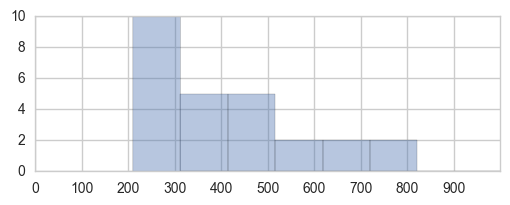

In [4]:
# count of each sign
plt.figure(figsize=(6,2))
plt.xlim(0,1000)
plt.xticks(np.arange(0, 1000, 100))
sns.distplot(np.bincount(y_train), kde=False, bins=20)

There are 13 classes of sign with less than 100 testing data points. The remaining 30 classes have betwen 100 and 800 testing data points, meaning the classes are not well balanced. We can generate more test data by transforming the existing pictures, such as rotating, blurring or sharpening, zooming in or out, or random disturbances in the pixel position.

Let's have a look at the sign images, to have an idea of how they are:

In [5]:
def print_images(dataset, imgs_row, title=""):
    
    imgs_col = int(len(dataset)/imgs_row)
    # set grid
    plt.figure(figsize=(imgs_row, imgs_col))
    grid = gs.GridSpec(imgs_col,imgs_row)
    grid.update(wspace=0.01, hspace=0.01)

    # create title
    plt.gcf().suptitle(title, fontsize=14)

    # plot images
    for idx, img in enumerate(dataset[:imgs_row*imgs_col]):
        ax = plt.subplot(grid[idx])
        ax.imshow(img)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

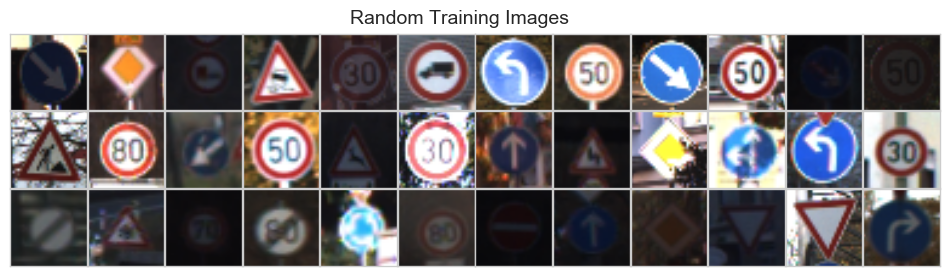

In [6]:
# get random indices
indices = np.random.permutation(X_train.shape[0])
print_images(X_train[indices[:36]], 12, "Random Training Images")

The images from both sets are generally ok, but they should be preprocessed before classifying. Most of them are centered, with 1 to 3 pixels margin on each side, but some are very clear while others are dark, blurry or colorless. All of the samples have 3 distinct channels, meaning none of them seem to be grayscale.

As these images are already centered and cropped, I will ignore for now the size of the original image and the coordinates of the bounding box around the traffic sign.

### Generating extra training data

Build a jittered dataset by adding transformed versions of the original training set.

Distortions are stochastic and applied to each preprocessed image during training, using random but bounded values for translation, rotation and scaling.  These values are drawn from a uniform distribution in a specified range:
* translation 1 pixel to any side
* zooming/scaling, maintaining center, from -7% to 7%
* +5 to -5 degrees for rotation.

In [7]:
# image transform functions
def scale(img):
    """ Scale to [.937, .969, 1.06]. Maintain center."""
    n = np.random.choice([-2,1,2]) 
    rdn = int(math.floor(-n/2))
    # zoom in
    if n > 0:
        img = cv2.resize(img[n:32-n, n:32-n], (32,32))
    # zoom out
    elif n < 0:
        img = cv2.resize(img, (32+n, 32+n))
        img = np.lib.pad(img, ((rdn,rdn), (rdn,rdn),(0,0)), 'edge')
    return img

def translate(img):
    """ Translate -1 or +1 pixel in any direction """
    w,h = np.random.randint(-1,2), np.random.randint(-1,2)
    M = np.float32([[1, 0, w], [0, 1, h]])
    return cv2.warpAffine(img, M, (32,32))

def rotate(img):
    """ Rotate -5 to +5 degrees """
    rot = np.random.randint(-5,6)
    M = cv2.getRotationMatrix2D((16,16), rot, 1)
    return cv2.warpAffine(img, M, (32,32))

def show(img):
    plt.figure(figsize=(3,3))
    ax = plt.imshow(img)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    
img = X_train[10]

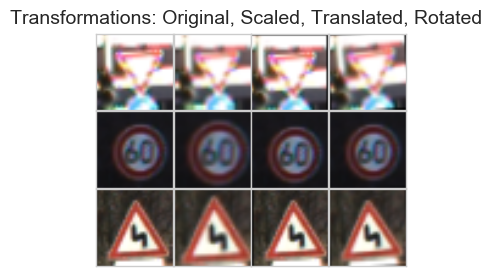

In [8]:
# visualize transformations
indices = np.random.permutation(X_train.shape[0])
images = X_train[indices][:3]
to_print = []
for img in images:
    to_print.append(img)
    for fn in [scale, translate, rotate]:
        to_print.append(fn(img))

print_images(to_print, 4, "Transformations: Original, Scaled, Translated, Rotated")

The transformations are subtle and hard to notice by visual inspection, but as shown later, they are essential for improving the overall score for the CNN model (note: experiment with more agressive transformations).

### Importing external data

In [9]:
import os
images = []
labels = []
for img in os.listdir('./'):
    if img[-3:] == 'jpg':
        images.append(cv2.resize(plt.imread(img), (32,32)))
        labels.append(int(img[:2]))

In [10]:
X_new = np.array(images)
y_new = np.array(labels)
X_new.shape, y_new.shape

((8, 32, 32, 3), (8,))

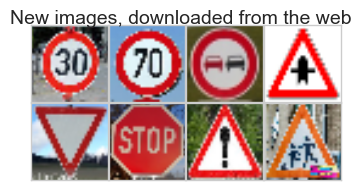

In [11]:
# visualize
print_images(X_new, 4, "New images, downloaded from the web")

### Preprocessing images

In [12]:
def process_image(img, yuv=True, histeq=True, adapthisteq=True, edge=True):
    """ Steps to enhance image prior to classification """
    # convert to YUV space, isolate Y channel
    if yuv:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)[:, :, 0]
    # preprocess Y with global histogram equalization (histeq)
    if histeq:
        img = cv2.equalizeHist(img)
    # preprocess Y with local histogram equalization (adapthisteq)
    if adapthisteq:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        img = clahe.apply(img)
    # edge detection - substract blurred image from original image
    if edge:
        gaussian_filter = cv2.GaussianBlur(img, ksize=(5,5), sigmaX=3)
        img = cv2.addWeighted(img, 1.5, gaussian_filter, -0.5, gamma=1)
    return img #.reshape(32, 32, 1)

def normalize(image_data):
    """ Normalize the image data with Min-Max scaling to a pre-defined range """
    x_min, x_max = 0, 255
    a, b = .01, .99
    return a + (image_data -  x_min)*(b-a)/(x_max-x_min)

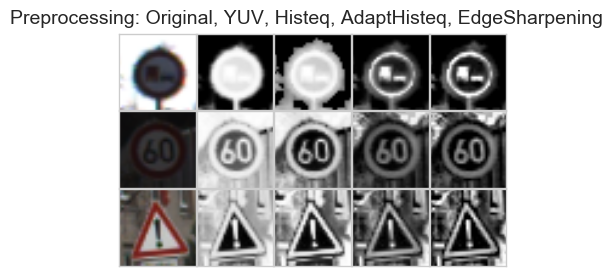

In [13]:
# visualize preprocessing
indices = np.random.permutation(X_train.shape[0])
images = X_train[indices][:3]
to_print = []
for img in images:
    to_print.append(img)
    to_print.append(process_image(img, histeq=False, adapthisteq=False, edge=False))
    to_print.append(process_image(img, adapthisteq=False, edge=False))
    to_print.append(process_image(img, edge=False))   
    to_print.append(process_image(img))
    
print_images(to_print, 5, "Preprocessing: Original, YUV, Histeq, AdaptHisteq, EdgeSharpening")

### Pipeline

In [14]:
# Adding new data: for each image, generate 3 more, one for each distortion
X_train = np.vstack((X_train,
                    np.array([translate(img) for img in X_train]),
                    np.array([rotate(img) for img in X_train]),
                    np.array([scale(img) for img in X_train])))

y_train = np.concatenate((y_train, y_train, y_train, y_train))

In [15]:
# Preprocess and normalize
X_train = normalize(np.array([process_image(img) for img in X_train]).reshape(-1,32,32,1))
X_test = normalize(np.array([process_image(img) for img in X_test]).reshape(-1,32,32,1))
X_new = normalize(np.array([process_image(img) for img in X_new]).reshape(-1,32,32,1))

In [16]:
# save data
np.save('variables', np.array([X_train, X_test, X_new, y_train, y_test, y_new]))

In [1]:
# additional imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import tensorflow as tf
from time import time
sns.set_style("whitegrid")

% matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Load files

In [2]:
X_train, X_test, X_new, y_train, y_test, y_new = np.load('variables.npy')
X_train.shape, X_test.shape, X_new.shape, y_train.shape, y_test.shape, y_new.shape

((156836, 32, 32, 1),
 (12630, 32, 32, 1),
 (8, 32, 32, 1),
 (156836,),
 (12630,),
 (8,))

### Split Validation Set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate= train_test_split(X_train, y_train, test_size=0.05, 
                                                            stratify=y_train, random_state=42)

# validation set was reduced to 5% for the final round
# it is only being used to know when to stop training nn

### Convolutional Neural Network - Model

In [4]:
# width of each layer
layer_width = {
    'layer_1': 100,
    'layer_2': 150,
    'layer_3': 250,
    'fc_1': 300
}

In [5]:
# fixed parameters
n_input = int(32*32)
n_classes = len(np.unique(y_train))
init_mean = 0
init_std = 0.03 # initial weight roughly between [-0.06, 0.06]
fc_input = 1000

# weights and biases
weights = {
    'layer_1': tf.Variable(
        tf.truncated_normal([7,7,X_train.shape[3],layer_width['layer_1']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'layer_2': tf.Variable(
        tf.truncated_normal([4,4,layer_width['layer_1'], layer_width['layer_2']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'layer_3': tf.Variable(
        tf.truncated_normal([4,4,layer_width['layer_2'], layer_width['layer_3']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'fc_1': tf.Variable(
        tf.truncated_normal([fc_input,layer_width['fc_1']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'out': tf.Variable(
        tf.truncated_normal([layer_width['fc_1'], n_classes], mean=init_mean, stddev=init_std), 
        trainable=True)
}

biases = {
    'layer_1': tf.Variable(
        tf.truncated_normal([layer_width['layer_1']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'layer_2': tf.Variable(
        tf.truncated_normal([layer_width['layer_2']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'layer_3': tf.Variable(
        tf.truncated_normal([layer_width['layer_3']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'fc_1': tf.Variable(
        tf.truncated_normal([layer_width['fc_1']], mean=init_mean, stddev=init_std), 
        trainable=True),
    'out': tf.Variable(
        tf.truncated_normal([n_classes], mean=init_mean, stddev=init_std),
        trainable=True)
}


In [6]:
# conv2d, bias, and relu activaton
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x,b)
    # x = tf.nn.relu(x)
    x = tf.tanh(x)
    return x

# max pool
def maxpool2d(x,k=2):
    x= tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')
    return x

In [7]:
# create neural net
def conv_net(x, weights, biases):
    
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1, k=2)
    
    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2, k=2) #adapted to remove conv3

    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])

    # Fully connected layer 1 - fc + relu
    conv3_reshaped = tf.reshape(conv3, [-1, fc_input])    
    fc1 = tf.add(tf.matmul(conv3_reshaped, weights['fc_1']), biases['fc_1'])
    # fc1 = tf.nn.relu(fc1)
    fc1 = tf.tanh(fc1)
    
    # Output layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out

In [8]:
# learning parameters
batch_size = 64
training_epochs = 300
decay = .01

### Convolutional Neural Network - Implementation

In [9]:
# graph input

# instead of batch_size, use None to allow for variable input
x = tf.placeholder(tf.float32, shape=(None, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, shape=(None))
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(5e-2, global_step, decay_steps=X_train.shape[0]/batch_size, 
                                           decay_rate=.96, staircase=True)
logits = conv_net(x, weights, biases)


In [10]:
# loss, optimizer, and variables initialization 
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits, y, name='xentropy')
loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')

# optimizer
tf.scalar_summary(loss.op.name, loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

#evaluation function
eval_correct = tf.reduce_sum(tf.cast(tf.nn.in_top_k(logits, y, 1),tf.float32))

#init
init = tf.initialize_all_variables()

In [11]:
# launch graph
t0 = time()
sess = tf.Session()
sess.run(init)

# create session variables
feed_dict={
    x: None,
    y: None
}

num_samples = 4000

# sample train and validation set
np.random.seed(42)
indices_train = np.random.permutation(y_train.shape[0])[:num_samples]
#indices_validate = np.random.permutation(y_validate.shape[0])[:num_samples]

# init scores
scores_train = []
scores_validate = []
losses = []
epochs = []

# training cycle
for epoch in range(1, training_epochs+1):

    # set size of batch
    total_batch = int(X_train.shape[0]/batch_size)+1

    # loop over batches
    for i in range(total_batch):                
        feed_dict[x] = X_train[i*batch_size:(i+1)*batch_size]
        feed_dict[y] = y_train[i*batch_size:(i+1)*batch_size]
        _, loss_value = sess.run([train_op, loss], feed_dict)

    # update last loss value
    losses.append(loss_value)

    # test model in training set
    feed_dict[x] = X_train[indices_train]
    feed_dict[y] = y_train[indices_train]
    true_count = sess.run(eval_correct, feed_dict) 
    scores_train.append(true_count / num_samples)

    # test model in validation set
    true_count = 0
    total_batch_validation = int(y_validate.shape[0]/num_samples)+1
    # loop over batches
    for i in range(total_batch_validation):                
        feed_dict[x] = X_validate[i*num_samples:(i+1)*num_samples]
        feed_dict[y] = y_validate[i*num_samples:(i+1)*num_samples]
        true_count += sess.run(eval_correct, feed_dict) 
    scores_validate.append(true_count / y_validate.shape[0])

    print("Epoch: {:0>4}, Cost: {:.8f}, Acc@Training: {:.3f}, Acc@Validate: {:.3f}".format(
            (epoch), losses[-1], scores_train[-1], scores_validate[-1]))        
    if epoch>1:
        #if scores_train[-1] >= 1:
        if (scores_validate[-1] < scores_validate[-2]) or (scores_validate[-1] > .998):
            break

print("Optimization Finished! Time to complete: {:.2f}".format(time()-t0))

Epoch: 0001, Cost: 0.18116899, Acc@Training: 0.829, Acc@Validate: 0.827
Epoch: 0002, Cost: 0.01294532, Acc@Training: 0.991, Acc@Validate: 0.988
Epoch: 0003, Cost: 0.00481423, Acc@Training: 0.997, Acc@Validate: 0.992
Epoch: 0004, Cost: 0.00231149, Acc@Training: 0.999, Acc@Validate: 0.995
Epoch: 0005, Cost: 0.00136663, Acc@Training: 0.999, Acc@Validate: 0.996
Epoch: 0006, Cost: 0.00092262, Acc@Training: 1.000, Acc@Validate: 0.997
Epoch: 0007, Cost: 0.00068672, Acc@Training: 1.000, Acc@Validate: 0.997
Epoch: 0008, Cost: 0.00054592, Acc@Training: 1.000, Acc@Validate: 0.997
Epoch: 0009, Cost: 0.00045553, Acc@Training: 1.000, Acc@Validate: 0.997
Epoch: 0010, Cost: 0.00038907, Acc@Training: 1.000, Acc@Validate: 0.997
Epoch: 0011, Cost: 0.00034094, Acc@Training: 1.000, Acc@Validate: 0.998
Epoch: 0012, Cost: 0.00030699, Acc@Training: 1.000, Acc@Validate: 0.998
Epoch: 0013, Cost: 0.00028191, Acc@Training: 1.000, Acc@Validate: 0.998
Epoch: 0014, Cost: 0.00026362, Acc@Training: 1.000, Acc@Validate

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


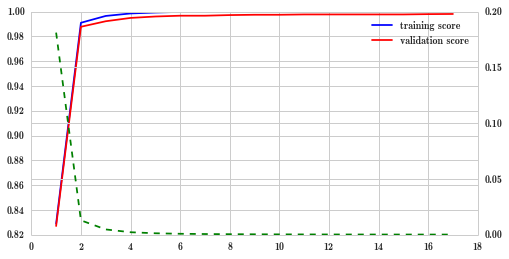

In [12]:
# create epochs
epochs = np.arange(1,len(scores_train)+1,1)

# set figure and axis
fig, ax1 = plt.subplots()
fig.set_size_inches((8,4))

# plot
ax1.plot(epochs, scores_train,'b-', label='training score')
ax1.plot(epochs, scores_validate, 'r-', label='validation score')
plt.legend()
ax2 = ax1.twinx()
ax2.plot(epochs, losses, 'g--', label='loss');

In [13]:
# test model in testing set
true_count = 0
batch_size = 1000
total_batch = int(y_test.shape[0]/batch_size)+1
# loop over batches
for i in range(total_batch):                
    t0= time()
    feed_dict[x] = X_test[i*batch_size:(i+1)*batch_size]
    feed_dict[y] = y_test[i*batch_size:(i+1)*batch_size]
    true_count += sess.run(eval_correct, feed_dict) 
score = true_count / y_test.shape[0]
print("Acc@Test: {:.3f}".format(score))         
   
# Non-transformed images: .936
# Transformed images, with 80% training set: .958
# Transformed images, with full training set: .960
# Transformed images, with full training set, tanh as non linear function: .970

Acc@Test: 0.970


In [14]:
# get probability distribution for new images
softmax_pred = tf.nn.top_k(tf.nn.softmax(logits), 5)
feed_dict[x] = X_new
feed_dict[y] = y_new
classes = sess.run(softmax_pred, feed_dict) 

In [15]:
for i in range(len(classes.values)):
    print(zip(classes.values[i], classes.indices[i]))
print y_new

[(0.99999487, 1), (1.8382967e-06, 0), (1.0728776e-06, 2), (9.9029455e-07, 6), (9.6554697e-07, 5)]
[(0.99998009, 9), (1.3907021e-05, 41), (2.5391014e-06, 16), (1.5097144e-06, 23), (5.3574547e-07, 35)]
[(0.99151868, 4), (0.0063370462, 0), (0.0021262243, 1), (6.1533524e-06, 18), (5.3878402e-06, 14)]
[(0.99995756, 11), (1.5105596e-05, 18), (1.1499011e-05, 40), (7.2709777e-06, 30), (3.691787e-06, 42)]
[(0.99819225, 18), (0.0015140012, 26), (0.00019332254, 11), (4.0405677e-05, 27), (3.9706778e-05, 37)]
[(0.99579155, 28), (0.002493473, 35), (0.00069932808, 36), (0.0001690522, 19), (0.00016574388, 32)]
[(0.93736994, 14), (0.033448607, 5), (0.020408753, 1), (0.0033263753, 8), (0.0018562834, 4)]
[(0.99999404, 13), (1.7098735e-06, 12), (1.3186822e-06, 15), (1.2444472e-06, 35), (3.6900687e-07, 39)]
[ 1  9  4 11 18 28 14 13]


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For image preprocessing, I took the following steps:
* Converted from RGB to YUV space, and isolated Y channel. The U and V channel were discarded
* Applied global histogram equalization, increasing contrast by transforming pixel intensities to a roughly uniform distribution
* Applied local histogram equalization, same as above, but in non-overlapping 4x4 frames that cover the entire image.
* Increased edge sharpness, by getting a blurred version of the image with gaussian filter and subtracting it from the original image.

These procedures are all addressed in the function `process_image()`. After preprocessing, I normalized the values for each pixel from 0 to 255 to 0.01 to 0.99 (function `normalize`).

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

During experimentation, I created a validation set with 20% of the original data. I would calculate accuracy at each epoch - to speed up, instead of calculating in the full set, I selected random subsets of the training and validation set at each epoch. In the final model, I've used full training data.

The test data was not used until I've got the final model. Tuning the hyperparameters based on accuracy on test data is a major source of data leakage and a common mistake in ML.

For the final model, I've created 3 more versions for each image in the training data, one rotated, one scaled, and one translated. The transformation parameters were randomly selected from a predefined range:
- Scale: scaled do .937, .969, 1.06 of the original image. These values were selecte to keep the 32x32 image centered. When zooming out, I padded the empty corners based on the values at the edges. 
- Translation: translated -1 ot +1 pixel for one or more directions (top, left, bottom, right)>
- Rotation: rotated -5 to +5 degrees.

With the new added images, the training set is 4x larger than the original set. The performance on the validation set increase from .985 to .991 with the addition of the new images, and up to .998 in the final model

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab142) from the classroom._


**Answer:**

Final architecture is a convolutional neural network, with the following layers:
* Convolutional, 7x7 kernel, resulting in 100 maps of 26x26 neurons
* MaxPool, 2x2 kernel, 100 maps of 13x13 neurons
* Convolution, 4x4 kernel, 150 maps of 10x10 neurons
* MaxPool, 2x2 kernel, 150 maps of 5x5 neurons
* Convolution, 4x4 kernel, 250 maps of 2x2 neurons
* Fully connected layer as a classifier, mapping 1000 neurons (2x2x250) to 300 neurons
* Fully connected layer, as the final output, mapping 300 neurons to 43 neurons

Each convolutional layer and the classifier were transformed with a simple non-linear function, rectified linear unit.

The architecture is heavily based on the article Multi-Column Deep Neural Network for Traffic Sign Classification, which describes the approach that won the final phase of the German traffic sign recognition benchmark [1] (not the same article described in the setup notebook). 

Some changes to mention here the large kernel in the first convolutional layer (7x7 in a 32x32 image), to detect large features in the initial convolution, and the last convolutional layer without max pooling.

A lot of improvements could be made such as implementing dropout to avoid overfitting, and trying other complex non linear activation functions rather than hyperbolic tangent or relu, such as described in [2]. In the final model I've used hyperbolic tangent in the convolutional layers and in the first fully connected layer. 

Another important improvement mentioned in [1] is training several DNNs, trained on different data, and averaging their output, a procedure described as Multi Column Deep Neural Network which yielded better results for the winning team at GTSRB competition.


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I trained the NN with a gradient descent optimizer. Final batch size for the full training data (close to 160,000 images) is 64, but I've tinkered with several batch sizes. Any batch size smaller than 16 would halt the kernel (I'm running the model on an Amazon instance p2x.large).

Learning rate was initialized to 0.05, with exponential decay of .96 each epoch. At each epoch I printed results of the last calculated loss (cost), the accuracy on a random set of 4,000 images of the testing set and on the full validation set, to evaluate the NN evolution accross epochs. 

The final model which reached the accuracy of 97% in the training set trained for 17 epochs, which corresponded to 12.5 minutes in 1 GPU with 12gb GPU memory (amazon instance p2.xlarge, the simplest one available with GPU).

In the final model, a small validation set of 5% of the data (which corresponds to roughly 8,000 samples) was used to gauge the optimal time to halt training. I've finished training as soon as the validation accuracy hit 99.8%, or if the validation accuracy for a given epoch was lower than the previous epoch (which is a major sign of overfitting).

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started with using a simple convolutional neural network described in the lessons (I started this project prior to the update in the CNN lessons). The results were below optimal, with less than 60% accuracy on the validation set. I was able to increase it to a little above 60% with some tinkering and implementing decaying learning rate.

Then I read some papers published regarding models applied to this dataset, but focused on [1] and [2], which gave me a lot of inspiration of next steps. The biggest change came from preprocessing the images, by isolating the Y channel, enhancing contrast and shaperning the edges. The accuracy results went from 60 to 90%. 

Finally I generate some additional jittered images to increase the training dataset, which raised the accuracy on validation set to over 99% and on test set to 96%. With the change of the linear function from rectified linear unit to hyperbolic tangent, and the implementation of a validation test to decide when to halt training, the performance on the validation set improved to 99.8% and on test set to 97.0% with the approximate same time of training (12 minutes on a single GPU).

If I would continue, next step would be trying to close the gap between validation set and test set. I would add even more images, add some sort of overfitting prevention such as regularization or droput, experiment with different non-linear activation functions, lower the training rate and train for more epochs or lower the batch size. Two other approaches I would look at is more complex non-linear functions [1] and using a committee of deep convolutional neural networks instead of a single one [2].

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chose 8 images, downloaded from the web, with the search tag "german traffic sign". I chose not to get pictures from my home country, Brazil, as the signs can be different form German. It would not make sense to test on something the nn has not been trained on (I wouldn't even be able to classify them in one of the 43 classes). I tried choosing images who had at least some small detail that would challenge the classifier. 

I manually cropped each picture using a photo editor tool, since there were only 8 images. They have small issues such as a watermark from the image provider, stickers, grafitti, rain or ertr taken from a different angle. 

My opinion is that there were a significant number traffic sign images given for training were in worst conditions than the images I captured in the web, such as blurred, low resolution, lacking contrast or brightness.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Yes, the model worked perfectly on the images, it got 8 out of 8 correct.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

For 7 of the 8 images the neural net guessed it correctly with over 99% confidence. Only one image, for class 14, guessed correctly with a probability of 93%. By visually inspecting image 14 I can see the main difference between it and the others is it was not cropped properly. It almost have no margin between the sign and the image border, while the other images have 1 to 2 pixels margin on each side. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

The 8 new test images were manually downloaded, cropped, and resized with opencv2. 

### References

[1] CireşAn, D., Meier, U., Masci, J. and Schmidhuber, J., 2012. Multi-column deep neural network for traffic sign classification. Neural Networks, 32, pp.333-338.

[2] Sermanet, P. and LeCun, Y., 2011, July. Traffic sign recognition with multi-scale convolutional networks. In Neural Networks (IJCNN), The 2011 International Joint Conference on (pp. 2809-2813). IEEE.

Other materials: TensorFlow documentation; Udacity SDCND lessons